In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cvxpy as cp
import polytope as pc
import torch
from torch.utils.data import Dataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from evanqp import MPCProblem, Polytope, RandomSampler, FFNN, Verifier
from evanqp.layers import BoundArithmetic
from utils import dlqr

In [3]:
class DoubleIntegrator(MPCProblem):
    def __init__(self, N=12):
        self.N = N

        n = 2
        m = 1

        # Double Integrator
        self.A = np.array([[1, 1], [0, 1]])
        self.B = np.array([[0], [1]])
        
        # Weights
        self.Q = np.diag([1, 1])
        self.R = np.array([[0.1]])
        self.K, self.P, _ = dlqr(self.A, self.B, self.Q, self.R)
        
        # Constraints
        self.x_max = np.array([10.0, 10.0])
        self.x_min = np.array([-10.0, -10.0])
        self.u_max = 1.0
        self.u_min = -1.0

        self.x0 = cp.Parameter(n, name='x0')
        self.x = cp.Variable((N + 1, n), name='x')
        self.u0 = cp.Variable(m, name='u0')
        self.u = cp.Variable((N, m), name='u')
        
        objective = 0
        constraints = [self.x0 == self.x[0, :], self.u0 == self.u[0, :]]
        for i in range(N):
            for j in range(self.Q.shape[0]):
                objective += self.Q[j, j] * cp.abs(self.x[i, j])
            for j in range(self.R.shape[0]):
                objective += self.R[j, j] * cp.abs(self.u[i, j])
            constraints += [self.x[i + 1, :] == self.A @ self.x[i, :] + self.B @ self.u[i, :]]
            constraints += [self.x_min <= self.x[i, :], self.x[i, :] <= self.x_max]
            constraints += [self.u_min <= self.u[i, :], self.u[i, :] <= self.u_max]
        constraints += [self.x[N, :] == 0]

        self.objective = cp.Minimize(objective)
        self._problem = cp.Problem(self.objective, constraints)

    def problem(self):
        return self._problem

    def parameters(self):
        return [self.x0]

    def variables(self):
        return [self.u0]

    def solve(self, x0):
        self.x0.value = x0
        self._problem.solve(solver=cp.GUROBI, warm_start=True)

        solution = {self.u0: self.u0.value,
                    self.u: self.u.value,
                    self.x: self.x.value,
                    self.objective: self.objective.value}
        return solution

    def reduced_objective(self):
        objective = 0
        for i in range(1, self.N):
            for j in range(self.Q.shape[0]):
                objective += self.Q[j, j] * cp.abs(self.x[i, j])
            for j in range(self.R.shape[0]):
                objective += self.R[j, j] * cp.abs(self.u[i, j])
        return cp.Minimize(objective)

In [4]:
mpc_controller = DoubleIntegrator()

In [6]:
x1 = np.linspace(-10, 10, 250)
x2 = np.linspace(-6, 6, 250)
x, y = np.meshgrid(x1, x2)
z_opt = np.zeros(x.shape)
for i in tqdm(range(x.shape[0])):
    for j in range(x.shape[1]):
        sol = mpc_controller.solve(np.array([x[i, j], y[i, j]]))
        u0 = sol[mpc_controller.variables()[0]]
        z_opt[i, j] = u0 if u0 is not None else None

100%|██████████| 250/250 [08:03<00:00,  1.93s/it]


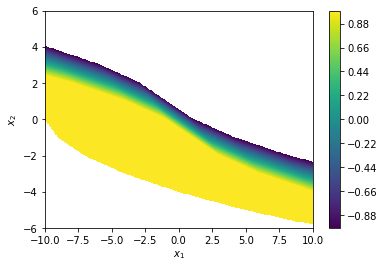

In [7]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_opt, levels=100)
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

In [8]:
parameter_set = Polytope(np.array([[1, 0], [-1, 0], [0, 1], [0, -1]]), np.array([10, 10, 10, 10]))

In [9]:
sampler = RandomSampler(mpc_controller, parameter_set)
parameter_samples, variable_samples = sampler.sample(10000, seed=0)

100%|██████████| 10000/10000 [03:01<00:00, 55.10it/s]


In [10]:
parameter_samples = torch.from_numpy(parameter_samples).float()
variable_samples  = torch.from_numpy(variable_samples).float()

torch.save(parameter_samples, 'parameter_samples_lp.pt')
torch.save(variable_samples, 'variable_samples_lp.pt')

In [11]:
class DoubleIntegratorDataset(Dataset):
    def __init__(self, parameter_samples, variable_samples):
        self.parameter_samples = parameter_samples
        self.variable_samples = variable_samples

    def __len__(self):
        return self.parameter_samples.shape[0]

    def __getitem__(self, idx):
        return self.parameter_samples[idx, :], self.variable_samples[idx, :]

In [12]:
dataset = DoubleIntegratorDataset(parameter_samples, variable_samples)

seed = 1
train_set_ratio = 0.8

train_set_size = int(len(dataset) * train_set_ratio)
test_set_size = len(dataset) - train_set_size
train_set, test_set = random_split(dataset, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(seed))

In [13]:
!python3 train.py --train-set-ratio {train_set_ratio} --seed {seed} --parameter-samples-file-name parameter_samples_lp.pt --variable-samples-file-name variable_samples_lp.pt --model-file-name double_integrator_ffnn_lp.pt

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.930184
Train Epoch: 1 [1280/8000 (16%)]	Loss: 0.997642
Train Epoch: 1 [2560/8000 (32%)]	Loss: 0.587937
Train Epoch: 1 [3840/8000 (48%)]	Loss: 0.664160
Train Epoch: 1 [5120/8000 (63%)]	Loss: 0.478123
Train Epoch: 1 [6400/8000 (79%)]	Loss: 1.226474
Train Epoch: 1 [7680/8000 (95%)]	Loss: 1.047615

Test set: Average loss: 0.728409)

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.737621
Train Epoch: 2 [1280/8000 (16%)]	Loss: 1.254852
Train Epoch: 2 [2560/8000 (32%)]	Loss: 1.513905
Train Epoch: 2 [3840/8000 (48%)]	Loss: 0.986476
Train Epoch: 2 [5120/8000 (63%)]	Loss: 0.471289
Train Epoch: 2 [6400/8000 (79%)]	Loss: 0.351155
Train Epoch: 2 [7680/8000 (95%)]	Loss: 0.153406

Test set: Average loss: 0.097041)

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.095429
Train Epoch: 3 [1280/8000 (16%)]	Loss: 0.027036
Train Epoch: 3 [2560/8000 (32%)]	Loss: 0.016458
Train Epoch: 3 [3840/8000 (48%)]	Loss: 0.046198
Train Epoch: 3 [5120/8000 (63%)]	Loss: 0.053128
Train Epoch: 3 [6400/8000 (7

In [14]:
parameter_samples = torch.load('parameter_samples_lp.pt')
variable_samples  = torch.load('variable_samples_lp.pt')

In [15]:
saved_model = torch.load('double_integrator_ffnn_lp.pt')

depth = saved_model['depth']
hidden_size = saved_model['hidden_size']

net = FFNN([hidden_size for _ in range(depth)], input_size=saved_model['input_size'], output_size=saved_model['output_size'])
net.load_state_dict(saved_model['state_dict'])

<All keys matched successfully>

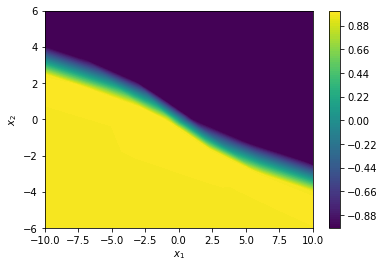

In [16]:
z_net = np.vstack((x.flatten(), y.flatten())).T
z_net = net(torch.from_numpy(z_net).float())
z_net = z_net.detach().cpu().numpy()
z_net = z_net.reshape(x.shape)

fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_net, levels=100)
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

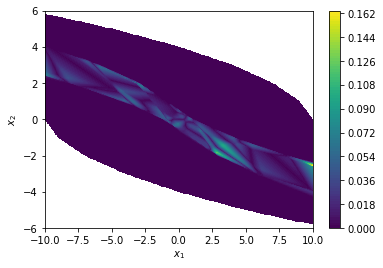

In [17]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

In [18]:
verifier = Verifier(parameter_set, mpc_controller, net)

In [19]:
mpc_bounds, net_bounds = verifier.compute_bounds(method=BoundArithmetic.INT_ARITHMETIC)
print('Neural Network Bounds:')
print(f'lower bound: {net_bounds["lb"]}')
print(f'upper bound: {net_bounds["ub"]}')

Neural Network Bounds:
lower bound: [-10.19932]
upper bound: [32.83601]


/Users/rschwan/Projects/evanqp/evanqp/layers/qp.py:176: UserWarning: QP Problem is not upper bounded, could lead to increased solve times.
  warnings.warn('QP Problem is not upper bounded, could lead to increased solve times.')


In [20]:
mpc_bounds, net_bounds = verifier.compute_bounds(method=BoundArithmetic.ZONO_ARITHMETIC)
print('Neural Network Bounds:')
print(f'lower bound: {net_bounds["lb"]}')
print(f'upper bound: {net_bounds["ub"]}')

Neural Network Bounds:
lower bound: [-9.17057]
upper bound: [26.62745]


In [21]:
bound, parameters = verifier.find_max_abs_diff()

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter Threads unchanged
   Value: 0  Min: 0  Max: 1024  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 763 rows, 628 columns and 2933 nonzeros
Model fingerprint: 0xcc719230
Model has 430 general constraints
Variable types: 409 continuous, 219 integer (219 binary)
Coefficient statistics:
  Matrix range     [9e-04, 1e+100]
  Objective range  [1e+00, 1e+00]
  Bounds range     [7e-02, 1e+03]
  RHS range        [2e-02, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

User MIP start produced solution with objective 0.00108055 (0.01s)
Loaded user MIP start with objective 0.00108055

Presolve removed 173 rows and 152 columns
Presolve time: 0.04s
Presolved: 590 rows, 476 columns, 2442 nonzeros
Presolved model has 34 SOS constraint(s)
Vari

In [22]:
print(f'Maximum absolute Error Bound between MPC and NN: {bound} at {parameters}')
u0_mpc = mpc_controller.solve(np.array(parameters))[mpc_controller.u0][0]
u0_net = net(torch.from_numpy(np.array(parameters)).float()).detach().numpy()[0]
print(f'Double Checking by calulcaing error at this position: {u0_mpc - u0_net}')

Maximum absolute Error Bound between MPC and NN: 0.17740447495249523 at [10.0, -2.5419727835601846]
Double Checking by calulcaing error at this position: 0.17740303694534765


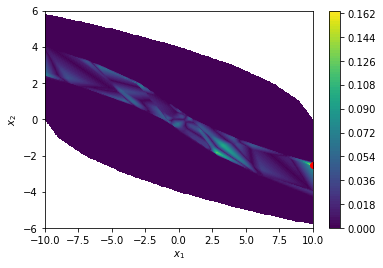

In [23]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
ax.plot(parameters[0], parameters[1], 'ro')
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

In [24]:
bound, parameters = verifier.verify_stability()

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter Threads unchanged
   Value: 0  Min: 0  Max: 1024  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 924 rows, 688 columns and 3192 nonzeros
Model fingerprint: 0x4dd9fe63
Model has 416 general constraints
Variable types: 475 continuous, 213 integer (213 binary)
Coefficient statistics:
  Matrix range     [9e-04, 1e+100]
  Objective range  [1e-01, 1e+00]
  Bounds range     [7e-02, 1e+03]
  RHS range        [2e-02, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

User MIP start produced solution with objective 0.0103093 (0.02s)
User MIP start produced solution with objective 0.00582425 (0.32s)
Loaded user MIP start with objective 0.00582425

Presolve removed 272 rows and 177 columns
Presolve time: 0.04s
Presolved: 652 rows, 511 co

In [25]:
print(f'Stability bound: {bound} at {parameters}, should be >=0 for stability')

Stability bound: -13.800022892391542 at [1.6131149749298856e-09, 0.004853542232699626], should be >=0 for stability
